# generate dummy variables & collect features

## Import Packages and load data

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("cleaned_data.csv",index_col='Unnamed: 0')

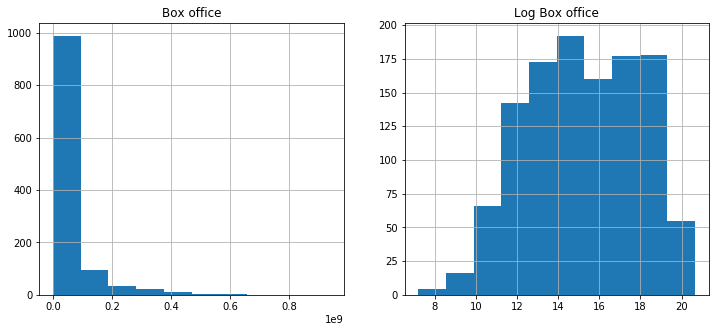

In [3]:
# using log(box office) for prediction
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
df['box_office'].hist()
plt.title('Box office')

plt.subplot(1,2,2)
np.log(df['box_office']).hist()
plt.title('Log Box office')

plt.show()

## generate dummy variables

In [4]:
# generate dummy variables for rating column
raw_data = pd.concat([df,pd.get_dummies(df['rating'],prefix = 'rating')],axis=1)

In [5]:
# generate dummy variables for studio column
def get_columns(df_column):
    l = []
    for ele in df_column:
        if ele!='na' and ele!='nan':
            l.extend(ele.split(', '))

    return set([x[1:-1] for x in l])

studio_list = get_columns(raw_data['studio'])
for ele in studio_list:
    raw_data['studio_'+str(ele).strip()]=np.where(raw_data["studio"].str.contains(ele),1,0)

In [6]:
# generate dummy variables for genre column
genre_list = get_columns(df['genre'])
for ele in genre_list:
    raw_data['genre_'+str(ele)]=np.where(df["genre"].str.contains(ele),1,0)

## Caculate days from the earliest movies

Intuition: Later movies are expected to have larger box office

In [7]:
# generate 'days_to_000401' column
earliest_date = datetime.strptime(raw_data['time'].min(),"%Y-%m-%d")
print('Earliest date in data:', earliest_date)

temp_list = []
for i in range(len(raw_data)):
    temp_list.append((datetime.strptime(raw_data.iloc[i]['time'],"%Y-%m-%d")-earliest_date).days)
raw_data['days_to_000401'] = temp_list

Earliest date in data: 2000-04-01 00:00:00


## Drop columns

In [8]:
cleaned_date = raw_data.drop(['meter_score','audience_score','name','rating','genre','cast', 'director', 'time','studio'],axis=1)

## Train, validation and test Split

In [9]:
from sklearn.model_selection import train_test_split

Y = np.log(cleaned_date['box_office'])
X = cleaned_date.drop(['box_office'],axis=1)
train_X, VT_X, train_Y, VT_Y = train_test_split(X,Y,test_size=0.2)
validation_X, test_X, validation_Y, test_Y = train_test_split(VT_X,VT_Y,test_size=0.5)
train_X.shape,validation_X.shape,test_X.shape,train_Y.shape,validation_Y.shape,test_Y.shape

((930, 374), (116, 374), (117, 374), (930,), (116,), (117,))

# Word Embedding

In [10]:
from gensim.models import Word2Vec
from nltk import tokenize
from nltk import word_tokenize

## Embedding model

In [11]:
corpus = []
for ele in train_X['movie_synopsis']:
    s = ele.lower()
    corpus.append(word_tokenize(s)) 

In [12]:
model = Word2Vec(corpus,size=100, window=5, min_count=1, workers=4)

## Transform train/validation/test data

In [13]:
def transform(x):
    vectors = []
    for ele in x:
        words = word_tokenize(ele.lower())
        total = 0
        vector = np.array([0]*100)
        for ele1 in words:
            try:
                vector = vector+model.wv[ele1]
                total += 1
            except:
                pass
        vector = vector/total*10
        vectors.append(vector)
    return vectors

In [14]:
# transform training data
word_embedding = pd.DataFrame(transform(train_X['movie_synopsis']),index=train_X.index)
train_X_we = train_X.join(word_embedding)
train_X_we.shape

(930, 474)

In [15]:
train_X_we.head()

,runtime,movie_synopsis,rating_G,rating_NC17,rating_NR,rating_PG,rating_PG-13,rating_R,studio_Village Roadshow',studio_'The Weinstein Company',...,90,91,92,93,94,95,96,97,98,99
1331,94,Flipping back and forth between the 18th centu...,0,0,0,0,0,1,0,0,...,2.337236,5.248883,1.364524,3.724325,11.596282,9.646227,-6.932783,1.411255,-1.431612,-16.268013
286,117,Matthew McConaughey stars in DALLAS BUYERS CLU...,0,0,0,0,0,1,0,0,...,2.253053,5.209550,1.290010,3.645523,11.455240,9.543464,-6.859856,1.372840,-1.338830,-16.039709
1663,112,Mild-mannered scientist Bruce Banner has been ...,0,0,0,0,1,0,0,0,...,2.389326,5.463634,1.360492,3.845735,12.053989,10.014504,-7.200775,1.458218,-1.432942,-16.856186
1095,87,A family struggles to go on after a devastatin...,0,0,0,0,0,1,0,0,...,2.505030,5.899346,1.367577,4.085153,12.964632,10.759757,-7.736104,1.479191,-1.415573,-18.027786
689,127,HIDDEN FIGURES is the incredible untold story ...,0,0,0,1,0,0,0,0,...,2.073546,5.022348,1.144095,3.412106,10.967946,9.179683,-6.553510,1.146452,-1.091280,-15.224534


In [16]:
# transform validation data
word_embedding = pd.DataFrame(transform(validation_X['movie_synopsis']),index=validation_X.index)
validation_X_we = validation_X.join(word_embedding)

# transform test data
word_embedding = pd.DataFrame(transform(test_X['movie_synopsis']),index=test_X.index)
test_X_we = test_X.join(word_embedding)

## Drop 'movie_synopsis' and rename

In [17]:
train_X = train_X_we.drop('movie_synopsis',axis=1)
validation_X = validation_X_we.drop('movie_synopsis',axis=1)
test_X = test_X_we.drop('movie_synopsis',axis=1)
train_X.shape,validation_X.shape,test_X.shape
del model

# Benchmark model: Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [32]:
OLS_model = LinearRegression()
OLS_model.fit(train_X,train_Y)
print('MSE on training set:', mean_squared_error(OLS_model.predict(train_X),train_Y))
print('MSE on validation set:',mean_squared_error(OLS_model.predict(validation_X),validation_Y))

MSE on training set: 1.0836231700981958
MSE on validation set: 3.702405009145883


# Random Forest and XGBoost

## Feature Selection: Lasso

In [20]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [21]:
Lasso_model = Lasso(alpha=0.0002,max_iter=1000000)
Lasso_model.fit(train_X,train_Y)
# train_X.columns[(Lasso_model.coef_==0)][-100:]

Lasso(alpha=0.0002, copy_X=True, fit_intercept=True, max_iter=1000000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [22]:
(Lasso_model.coef_==0).sum()

140

In [23]:
drop_list = train_X.columns[(Lasso_model.coef_==0)]
train_X = train_X.drop(drop_list,axis=1)
validation_X = validation_X.drop(drop_list,axis=1)
test_X = test_X.drop(drop_list,axis=1)
train_X.shape[1]

333

## Random Forest

In [24]:
selection_model = GridSearchCV(RandomForestRegressor(),
                             {'n_estimators':[80,160,320],'max_features':[15,30,60,120,200],'max_depth':[3,5,8,16,None]},
                             cv=5)
%time selection_model.fit(train_X,train_Y)
selection_model.best_estimator_

CPU times: user 4min 20s, sys: 3.16 s, total: 4min 23s
Wall time: 4min 36s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
           max_features=120, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=320, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [26]:
best_rf_model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
           max_features=120, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=320, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
best_rf_model.fit(train_X,train_Y)

print('MSE on training set:', mean_squared_error(best_rf_model.predict(train_X),train_Y))
print('MSE on validation set:',mean_squared_error(best_rf_model.predict(validation_X),validation_Y))

MSE on training set: 0.4163763531748863
MSE on validation set: 3.6782307866461825


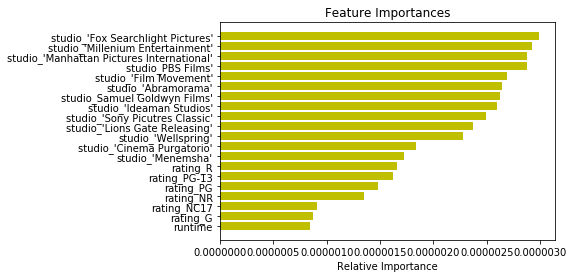

In [27]:
feature_names = [i for i in train_X.columns]
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(20), importances[indices][0:20], color='y', align='center')
plt.yticks(range(20),feature_names[0:20])
plt.xlabel('Relative Importance')
plt.show()

## XGBoost

In [28]:
from xgboost import XGBRegressor

In [29]:
XGB_selection_model = GridSearchCV(XGBRegressor(),
                                 {'min_child_weight':[0.25,0.5,1,2,4],'colsample_bytree':[0.5,0.6,0.7,0.8,0.9,1],
                                  'max_depth':[3,5,7,9]},
                                 cv=5)
%time XGB_selection_model.fit(train_X,train_Y)
XGB_selection_model.best_estimator_

CPU times: user 7min 46s, sys: 6.25 s, total: 7min 52s
Wall time: 8min 15s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=4, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [30]:
best_XGB = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=4, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
best_XGB.fit(train_X,train_Y)
mean_squared_error(best_XGB.predict(train_X),train_Y)

print('MSE on training set:', mean_squared_error(best_XGB.predict(train_X),train_Y))
print('MSE on validation set:',mean_squared_error(best_XGB.predict(validation_X),validation_Y))

MSE on training set: 1.6225634876564121
MSE on validation set: 3.551087928879539


# Prediction for Box office

## model selection

According to validation data
- mean square error of Linear Regression:  3.702405009145883 
- mean square error of Random Forest:  3.6782307866461825
- mean square error of XGBoost:  3.551087928879539

Therefore Random Forest will be chosen for prediction.

In [31]:
final_train_X = pd.concat([train_X,validation_X])
final_train_Y = pd.concat([train_Y,validation_Y])
best_XGB.fit(final_train_X,final_train_Y)
mean_squared_error(best_XGB.predict(test_X),test_Y)

2.291005589375202

## Predicted Box Office

The example input for model is illstrated as follows 

- First, the raw input should be cleaned by the preprocessing ipynb file (actor_score and director_score could be calculated in that file)
- Next, the cleaned input should be processed by the ML & WE prediction ipynb file, and will be ready for the model

In [33]:
# example input after data preprocessing
df.iloc[:1]

,name,meter_score,audience_score,rating,genre,cast,director,time,studio,runtime,box_office,movie_synopsis
0,Toy Story 3,98,89,G,"['Animation', 'Comedy', 'Kids & Family', 'Scie...","['Tom Hanks', 'Tim Allen', 'Joan Cusack', 'Ned...",['Lee Unkrich'],2010-06-18,['Walt Disney Pictures'],103,414984497.0,"""Toy Story 3"" welcomes Woody, Buzz and the who..."


In [34]:
# example input for model prediction
train_X[:1]

,runtime,rating_G,rating_NC17,rating_NR,rating_PG,rating_PG-13,rating_R,studio_'Menemsha',studio_'Cinema Purgatorio',studio_'Wellspring',...,41,45,53,64,66,75,79,80,81,88
1331,94,0,0,0,0,0,1,0,0,0,...,3.127892,1.489561,1.540268,-10.764084,3.885459,-4.385925,-16.398596,0.031341,-3.953347,9.97593


In [75]:
# example prediction by XGBoost model
log_box_office = best_XGB.predict(test_X.iloc[1:2])
box_office = np.exp(log_box_office)
print('predicted box office:\t', box_office[0])
print("real box office:\t",np.exp(test_Y.iloc[1:2]).values[0])

predicted box office:	 1063724.4
real box office:	 1324335.0000000005


In [72]:
np.exp(test_Y.iloc[1:2])

1443    1324335.0
Name: box_office, dtype: float64